# AN2DL - Apple Elixir

This notebook contains code of a neural network used in a competition. The goal of the competition was to classify plants into two classes (healthy and unhealthy).
The model used in this notebook derived from a well known architecture, ConvNeXt, and uses an advanced augmentation technique called MixUp combined with more traditional augmentation techniques

# Import and configs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.9 MB/s eta 0:00:00


In [3]:
!pip install --upgrade keras-cv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.7 MB/s eta 0:00:00


**Imports**

In [4]:
# Default Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv as kcv
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

Using TensorFlow backend


**import of the dataset**

this dataset, as presented in the report, is derved from the original one by oversampling the elements in the less represented class

In [ ]:
!wget -q https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced.npz

**Randomnes and Configurations**

In [5]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**TPU Setup**

In [6]:
use_tpu = True#@param {type:"boolean"}

if 'COLAB_TPU_ADDR' in os.environ and use_tpu:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  use_tpu = False


if use_tpu:
  tpu_address = TF_MASTER
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

**Defining Functions**

In [7]:
# Plotting Functions
# Function used for plotting the loss
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

# Function used for compute the confusion Matrix
def plot_confusion_matrix(model, test, figsize, name_jpg):
  # Compute the confusion matrix
  y_pred = model.predict(test, verbose=0, steps=(len(X_val) // BATCH_SIZE))
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  cm = confusion_matrix(true_categories, y_pred)

  # Compute classification metrics
  accuracy = accuracy_score(true_categories, y_pred)
  precision = precision_score(true_categories, y_pred, average='macro')
  recall = recall_score(true_categories, y_pred, average='macro')
  f1 = f1_score(true_categories, y_pred, average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(name_jpg)
  plt.show()

# Function used for printig a set of images and their corresponding labels
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")


# Function used to make predictions
def test_prediction(model, test):
  y_pred = model.predict(test, verbose=0, steps=(len(X_val) // BATCH_SIZE))
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  test_accuracy = accuracy_score(true_categories, y_pred)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

# Function used to plot 9 images belonging to the dataset
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Data Initizialization

**load the dataset**

In [8]:
# Initializate
images, labels = np.load('public_data_clean_balanced.npz', allow_pickle=True).values()

print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

# Map the categorical attributes into numbers
labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])

Images shape:  (6120, 96, 96, 3)
Labels shape:  (6120,)


In [9]:
# Split the set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = labels
)

# Convert the categorical attributes in one-hot encoding
y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)

# Get the Shape of IN OUT
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



**convert the dataset into a TensorFlow Dataset**

In [10]:
# create a dataset object for each set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

**Preprocess the data**

In [11]:
# Assign the batch size
if use_tpu:
  BATCH_SIZE = 32
else:
  BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (96, 96)

# This function create a dictionary composed of images and labels
def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}


def prepare_trainset(dataset):
    return (
            dataset
            .cache()
            .shuffle(1000, reshuffle_each_iteration=True)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

def prepare_valset(dataset):
    return (
            dataset
            .cache()
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

## Augmentation

**Augmentation Layers**

In [12]:
# Used to convert a keras layer into a keras_cv layer
class KerasToCV(kcv.layers.BaseImageAugmentationLayer):
    def __init__(self, keras_layer, seed=None, **kwargs):
        super().__init__(seed=seed, **kwargs)
        self.seed = seed
        self.keras_layer = keras_layer

    def augment_image(self, image, transformation, **kwargs):
        return self.keras_layer(image)

    def augment_label(self, label, transformation, **kwargs):
        return label

    def get_config(self):
        config = {
            "seed": self.seed,
            "keras_layer": self.keras_layer,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
# Randomly rotate by 90 degrees and flip the images
class Random90RotFlip(kcv.layers.BaseImageAugmentationLayer):
    def __init__(self, seed=None, **kwargs):
        super().__init__(seed=seed, **kwargs)
        self.seed = seed
        self._ops = [lambda x: x]
        for j in range(1, 4):
            self._ops.append(lambda x: tf.image.rot90(x, k=j+1))
        self._ops.append(lambda x: tf.image.flip_up_down(x))
        for j in range(1, 4):
            self._ops.append(lambda x: tf.image.rot90(tf.image.flip_up_down(x), k=j+1))

    def augment_image(self, image, transformation, **kwargs):
        # randomly apply one of the 8 possible transformations
        if self.seed is not None:
            np.random.seed(self.seed)
        return self._ops[np.random.randint(8)](image)

    def augment_label(self, label, transformation, **kwargs):
        return label

    def get_config(self):
        config = {
            "seed": self.seed,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

**Define other augmentation layers**

In [30]:
def get_cust_pipeline():
  rotation_rate=0.7
  zoom_rate=0.5
  grayscale_rate=0.3
  mix_up_rate=0.6
  color_jitter_rate=0.6
  traslation_rate=0.7


  pre_process = Random90RotFlip()
  rand_rotation = kcv.layers.RandomApply(
                      KerasToCV(tkl.RandomRotation(factor=0.25)),
                      rate=rotation_rate,
                  )
  rand_zoom = kcv.layers.RandomApply(
                  KerasToCV(tkl.RandomZoom(
                      height_factor=(-0.3, 0.3),
                      width_factor=(-0.3, 0.3))
                  ),
                  rate=zoom_rate,
              )
  gray_scale = kcv.layers.RandomApply(
                  kcv.layers.Grayscale(output_channels=3),
                  rate=grayscale_rate,
              )
  rand_color_jitter = kcv.layers.RandomApply(
                          kcv.layers.RandomColorJitter(
                                              value_range=(0, 255),
                                              brightness_factor=0.1,
                                              contrast_factor=0.5,
                                              saturation_factor=(0.5, 0.6),
                                              hue_factor=0.2,
                                          ),
                          rate=color_jitter_rate,
                      )
  rand_traslation = kcv.layers.RandomApply(
                        KerasToCV(tkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)))
                        ,
                        rate=traslation_rate,
                      )
  mix_up = kcv.layers.RandomApply(
              kcv.layers.MixUp(),
              rate=mix_up_rate,
              batchwise=True,
          )

  classic_aug = tfk.Sequential([
      rand_rotation,
      rand_zoom,
      gray_scale,
      rand_color_jitter,
  ])

  cust_pipeline = tfk.Sequential([
      pre_process,
      kcv.layers.RandomChoice([
          classic_aug,
          mix_up,
      ], batchwise=True),
  ])

  return cust_pipeline

**Apply the augmentations to our dataset**

In [31]:
if use_tpu:
  with strategy.scope():
    cust_pipeline = get_cust_pipeline()
else:
  cust_pipeline = get_cust_pipeline()

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

train_dataset = (
    train_dataset
    .map(cust_pipeline, num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

# Define the Model

In [33]:
from keras.applications.convnext import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  # From Keras.application import ConvNeXt Base
  res = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )
  # Set convNeXt as not trainable
  res.trainable = False

  input_layer = tkl.Input(input_shape)  # input layer

  x = preprocess_input(input_layer)
  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x)
  x = tkl.Dense(units=128,activation=tkl.LeakyReLU(alpha=0.3))(x)
  x = tkl.Dropout(0.7)(x)
  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)

  model = tfk.Model(input_layer, output_layer)
  auc = tfk.metrics.AUC(name='auc')

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.001),
      metrics=['accuracy', auc]
  )

  return model

if use_tpu:
  with strategy.scope():
    model = apple_elixir_model(input_shape,output_shape)
else:
  model = apple_elixir_model(input_shape,output_shape)

350926856/350926856 [==============================] - 6s 0us/step


# Training

**CallBacks**

In [ ]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

# Reduce LR on plateau
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,                          
    factor=0.85,                                  
    mode='max',                                     
    min_lr=1e-7                                     
)

callbacks = [early_stopping, lr_scheduler]

**Fit the model**

In [34]:
history = model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
162/162 [==============================] - 49s 133ms/step - loss: 0.9051 - accuracy: 0.5584 - auc: 0.5729 - val_loss: 0.5149 - val_accuracy: 0.7679 - val_auc: 0.8355 - lr: 1.0000e-04
Epoch 2/300
162/162 [==============================] - 8s 50ms/step - loss: 0.6547 - accuracy: 0.6688 - auc: 0.7092 - val_loss: 0.4493 - val_accuracy: 0.7924 - val_auc: 0.8828 - lr: 1.0000e-04
Epoch 3/300
162/162 [==============================] - 8s 52ms/step - loss: 0.6076 - accuracy: 0.7079 - auc: 0.7367 - val_loss: 0.4075 - val_accuracy: 0.8214 - val_auc: 0.9064 - lr: 1.0000e-04
Epoch 4/300
162/162 [==============================] - 9s 55ms/step - loss: 0.5616 - accuracy: 0.7301 - auc: 0.7702 - val_loss: 0.4025 - val_accuracy: 0.8237 - val_auc: 0.9027 - lr: 1.0000e-04
Epoch 5/300
162/162 [==============================] - 9s 57ms/step - loss: 0.5476 - accuracy: 0.7448 - auc: 0.7759 - val_loss: 0.3931 - val_accuracy: 0.8259 - val_auc: 0.9064 - lr: 1.0000e-04
Epoch 6/300
162/162 [============

### Saving and Plotting

In [35]:
NAME_MODEL = "ConvNeXtCV_Cust_Pipe_003"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Plots Loss**

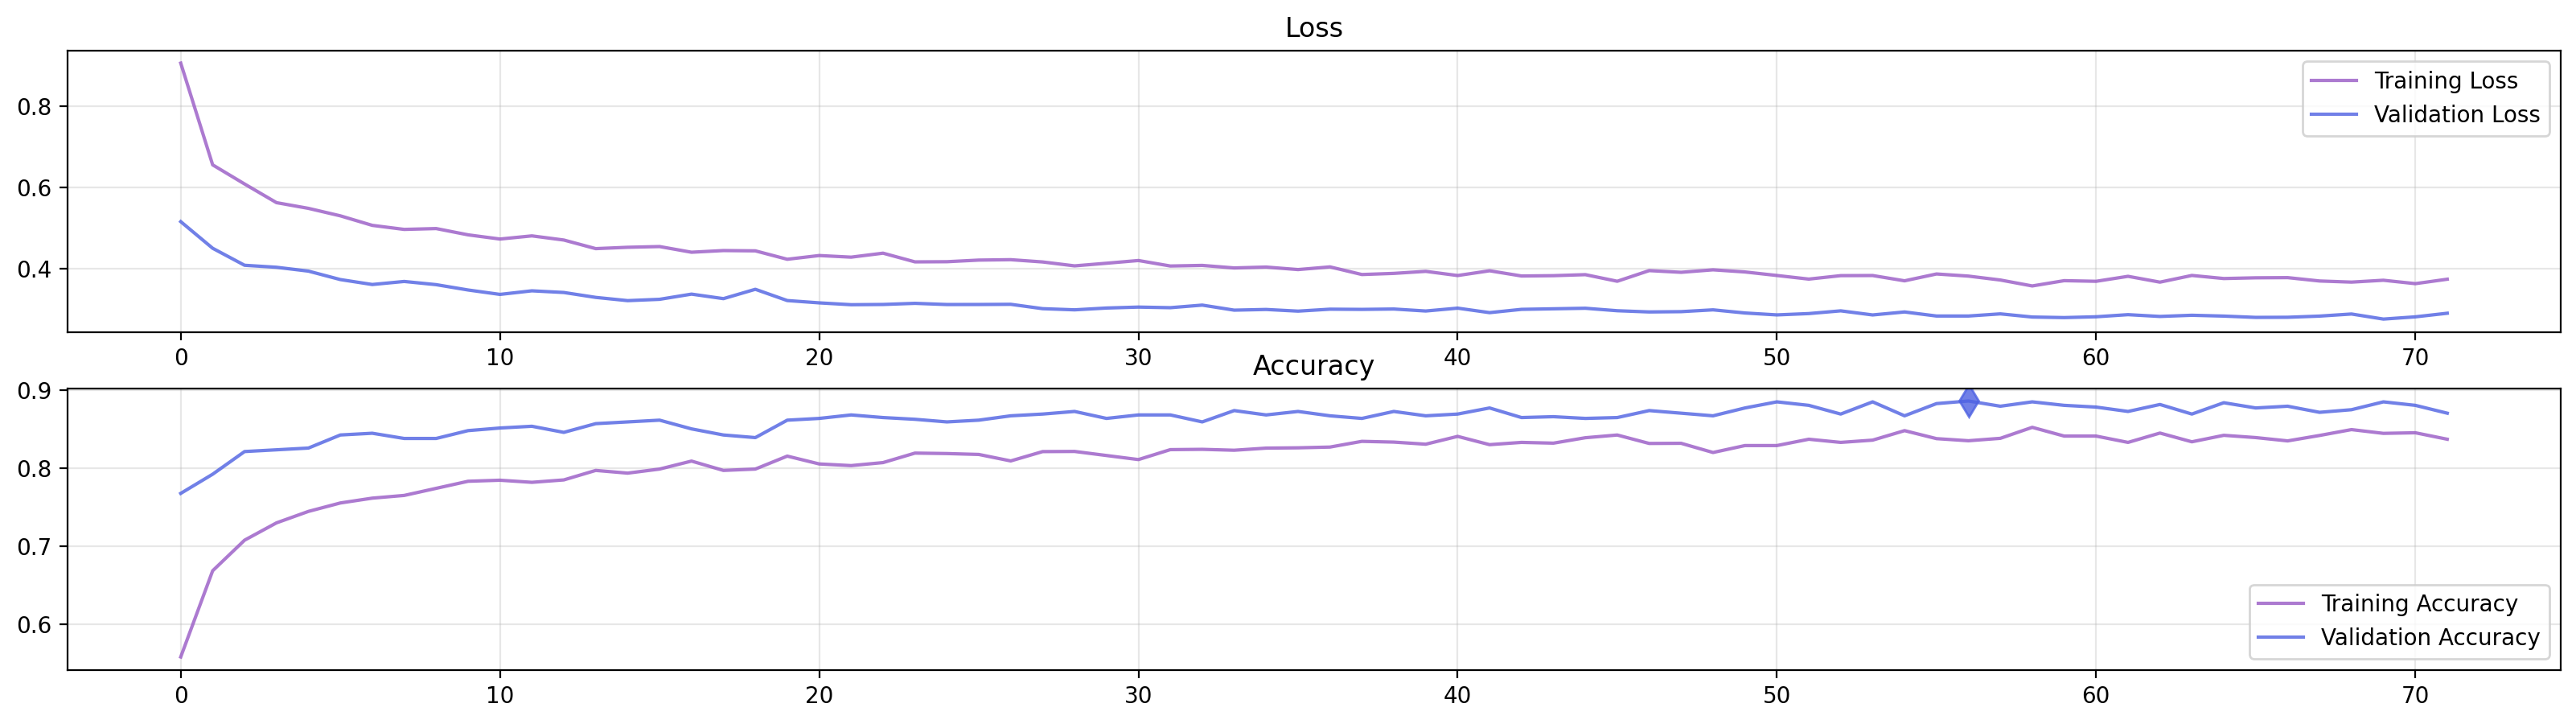

In [36]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

In [ ]:
plot_confusion_matrix(model, val_dataset, len(X_val) // BATCH_SIZE, (5,4), NAME_CMATRIX)

**Save the Model**

In [37]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  model.save(NAME_MODEL, options=save_locally)
else:
  model.save(NAME_MODEL)

**Zip Model and Plots**

In [38]:
!zip -q -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

In [39]:
!cp {NAME_MODEL}.zip drive/MyDrive/

# Fine Tuning

**Load the Model**

In [40]:
if use_tpu:
  with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    ft_model = tf.keras.models.load_model(NAME_MODEL, options=load_locally)
else:
  ft_model = tfk.models.load_model(NAME_MODEL)

**Train only the Last Layers**

In [42]:
ft_model.get_layer('convnext_base').trainable = True

# Fine-tune from N_LAYERS onwards (CHANGE FOR DIFFERENT FINE TUNING)
N_LAYERS = 200
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:N_LAYERS]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.001), metrics=['accuracy'])

**Train the Tuning Model**

In [44]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=35,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',        
    patience=5,                   
    factor=0.80,                    
    mode='max',                     
    min_lr=1e-7                     
)

callbacks = [early_stopping, lr_scheduler]

history = ft_model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
162/162 [==============================] - 100s 150ms/step - loss: 0.3951 - accuracy: 0.8287 - val_loss: 0.2484 - val_accuracy: 0.8973 - lr: 1.0000e-04
Epoch 2/300
162/162 [==============================] - 11s 71ms/step - loss: 0.3218 - accuracy: 0.8702 - val_loss: 0.2251 - val_accuracy: 0.9141 - lr: 1.0000e-04
Epoch 3/300
162/162 [==============================] - 9s 54ms/step - loss: 0.2759 - accuracy: 0.8927 - val_loss: 0.2339 - val_accuracy: 0.9107 - lr: 1.0000e-04
Epoch 4/300
162/162 [==============================] - 11s 70ms/step - loss: 0.2530 - accuracy: 0.9128 - val_loss: 0.1976 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 5/300
162/162 [==============================] - 10s 65ms/step - loss: 0.2333 - accuracy: 0.9223 - val_loss: 0.1925 - val_accuracy: 0.9219 - lr: 1.0000e-04
Epoch 6/300
162/162 [==============================] - 11s 71ms/step - loss: 0.2221 - accuracy: 0.9219 - val_loss: 0.1787 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 7/300
162/162 [======

### Saving and Plotting

In [45]:
FT_NAME = NAME_MODEL+"_Tuning" + "_1"
FT_PLOT = NAME_PLOT+"_Tuning" + "_1"
FT_CMATRIX = NAME_CMATRIX+"_Tuning" + "_1"

**Plot Loss**

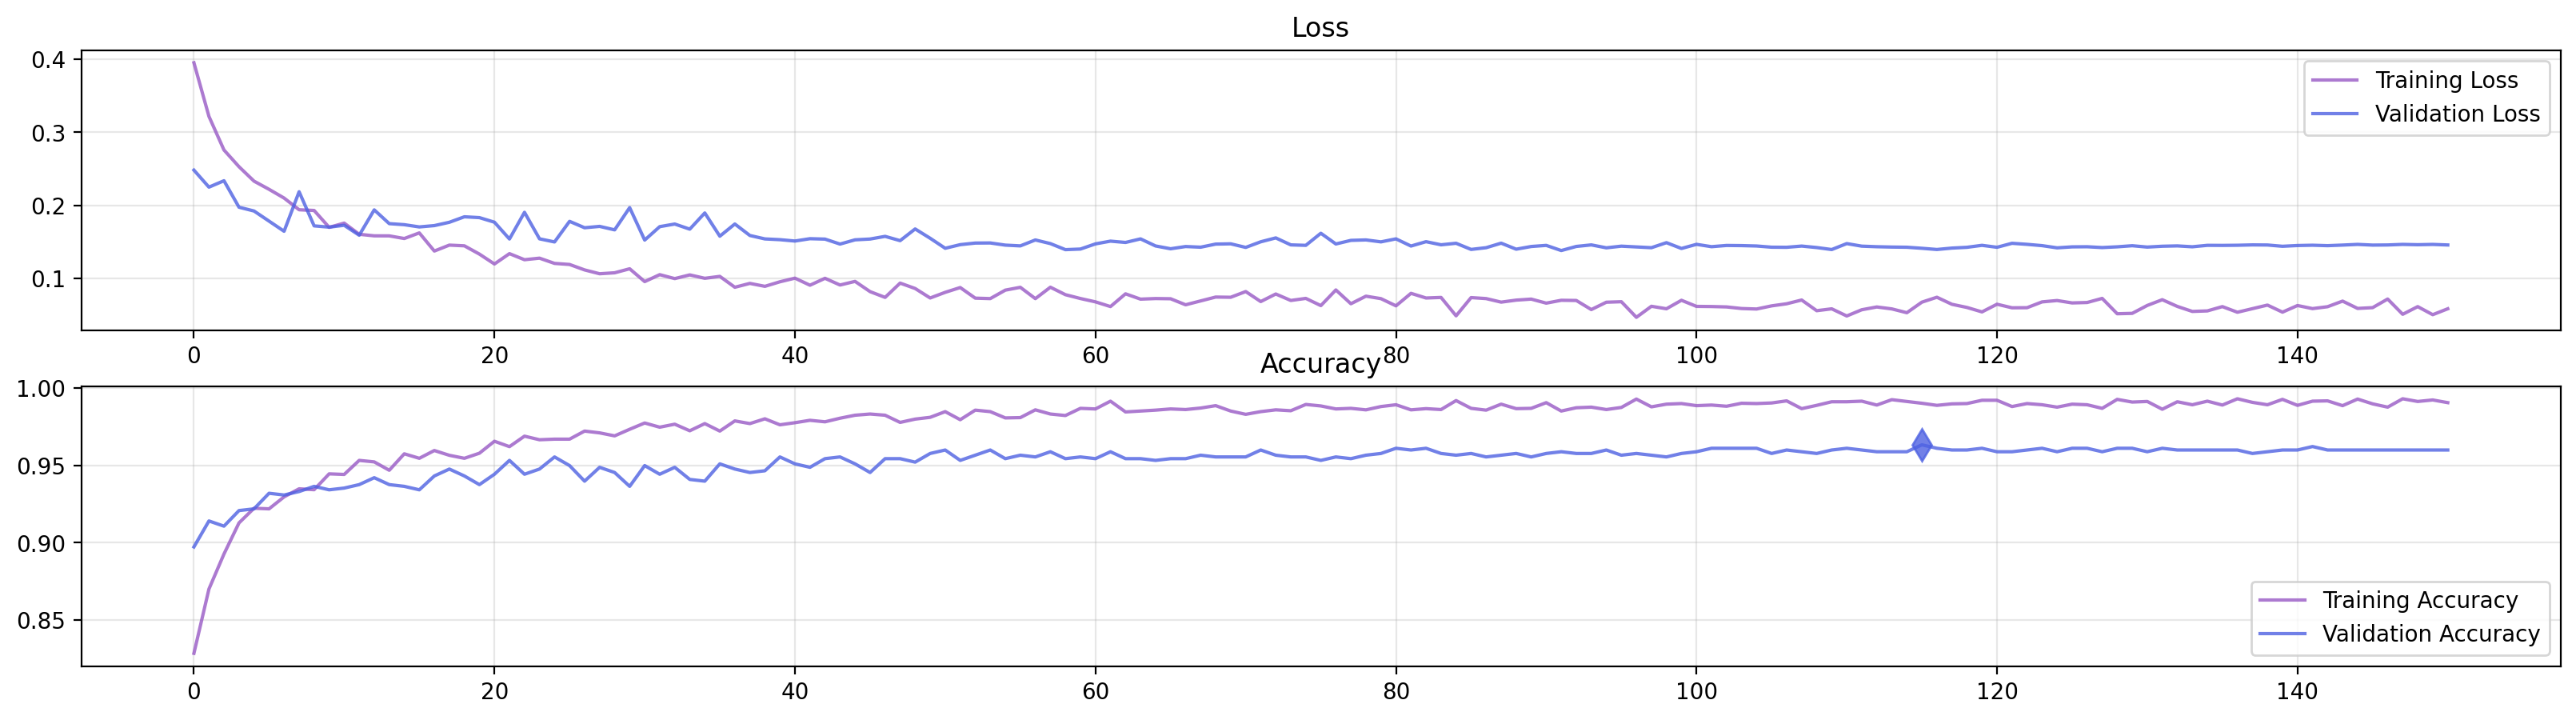

In [54]:
plot_losses(history, (20,5), FT_PLOT)

**Plot Confusion Matrix**

In [ ]:
plot_confusion_matrix(ft_model, val_dataset, len(X_val) // BATCH_SIZE, (5,4), FT_CMATRIX)

**Save the Model**

In [47]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  ft_model.save(FT_NAME, options=save_locally)
else:
  ft_model.save(FT_NAME)

# Zip the Model and the Plots

In [48]:
!zip -q -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png

!cp {FT_NAME}.zip drive/MyDrive/

# Notes
We would like to thank the team of the 2023/2024 AN2DL course taught at Politecnico di Milano

More code available at this link: https://github.com/GioBar00/AN2DL_23-24_Apple_Elixir

Credits:
>*Andrea Alari*   https://github.com/andrea-alari

>*Giovanni Barbiero* https://github.com/GioBar00

>*Alexandro Sas*  https://github.com/AlexandroSas